<div style="
    background: linear-gradient(90deg, #c8102e 0%, #002868 100%);
    color: white;
    padding: 18px 22px;
    border-left: 6px solid #002868;
    border-right: 6px solid #c8102e;
    border-top: 3px solid #002868;
    border-bottom: 3px solid #002868;
    border-radius: 8px;
    box-shadow: 0 2px 8px rgba(0,0,0,0.18);
    font-family: 'Segoe UI', -apple-system, BlinkMacSystemFont, sans-serif;
">
     <h1 style="
      margin: 0 0 6px 0;
      font-size: 30px;
      font-weight: 700;
      letter-spacing: 0.03em;
      text-transform: uppercase;
      color: white;
  ">
Regional Price Behavior in Haiti: Time Series Decomposition and ARIMA Forecasts  </h1>
</div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # force integer type on xaxis

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
# Load dataset
file_id = "1VyLHX20ofimGB7jhFhhw06MBu9Ajod4o"
url = f"https://drive.google.com/uc?download&id={file_id}"
haiti_df = pd.read_csv(url)
print(haiti_df.head())

         date  Department      City    market  latitude  longitude  \
0  2005-01-15  Artibonite  Gonaives  Gonaives     19.45 -72.683333   
1  2005-01-15  Artibonite  Gonaives  Gonaives     19.45 -72.683333   
2  2005-01-15  Artibonite  Gonaives  Gonaives     19.45 -72.683333   
3  2005-01-15      Centre    Hinche    Hinche     19.15 -72.016667   
4  2005-01-15      Centre    Hinche    Hinche     19.15 -72.016667   

            food_type               commodity     unit  usdprice  
0  cereals and tubers      Maize meal (local)  Marmite    0.4554  
1  cereals and tubers           Rice (tchako)  Marmite    0.7135  
2  cereals and tubers  Wheat flour (imported)  Marmite    0.4554  
3  cereals and tubers   Maize meal (imported)    Pound    0.0999  
4  cereals and tubers      Maize meal (local)  Marmite    0.2733  




---



In [4]:
# Convert date column to datetime
haiti_df['date'] = pd.to_datetime(haiti_df['date'])

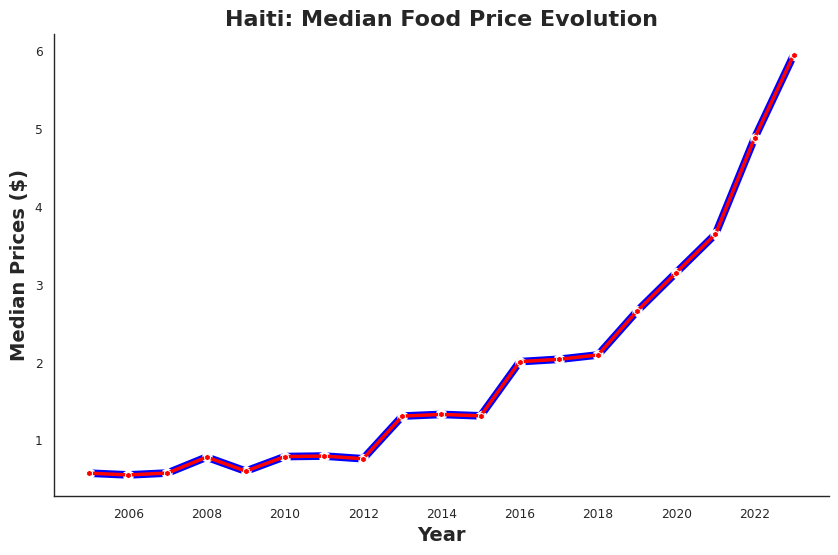

In [5]:
# Create year column and fetch only years
haiti_df['year'] = haiti_df['date'].dt.year.astype(int)

# Group median prices by year
yearly_prices = haiti_df.groupby('year')['usdprice'].median().reset_index()

# Custom plot
sns.set_style('white')
sns.set_context('paper')

# Overall median price lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_prices, x='year', y='usdprice', linewidth=5.5, color='blue', marker='h',
markerfacecolor='white', markeredgecolor= 'white',markeredgewidth=3.2)
sns.lineplot(data=yearly_prices, x='year', y='usdprice', linewidth=2.5, color='red', marker='h')
plt.title("Haiti: Median Food Price Evolution", fontsize=16,weight='bold')
plt.ylabel("Median Prices ($)", weight='bold', fontsize=14)
plt.xlabel("Year", weight='bold', fontsize=14)

# Force integer ticks on x-axis to get years with proper format
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# Remove top and right spines on plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

### **Median Food Prices in Haiti: Regional Trends Over Time**

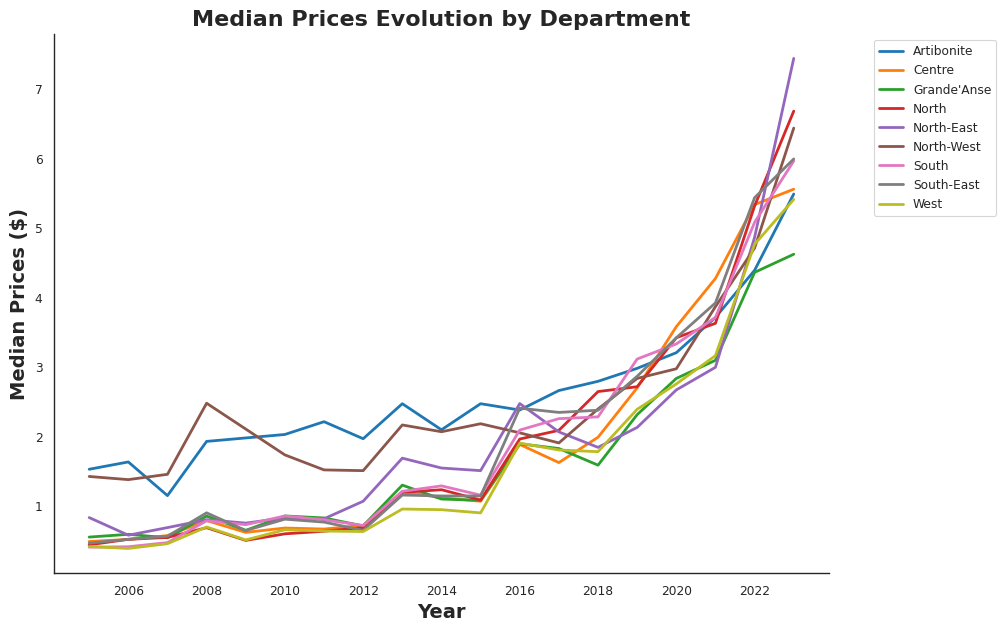

In [6]:
# Group median prices by department and year
dept_year = haiti_df.groupby(['Department', 'year'])['usdprice'].median().reset_index()

# Lineplot for each department
plt.figure(figsize=(10, 7))
sns.lineplot(data=dept_year, x='year', y='usdprice', hue='Department', linewidth=2)
plt.title("Median Prices Evolution by Department", weight='bold', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Year", weight='bold', fontsize=14)
plt.ylabel("Median Prices ($)", weight='bold', fontsize=14)
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(nbins=10,integer=True)) # ensure xaxis shows integer
# Remove top and right spines on plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

#### Comment:
The convergence and collective rise post-2019 hints at a **nationwide pressure on food affordability**, not just isolated spikes.

<br></br>
### **Security Issues as a Driver?**
Armed groups have expanded their reach, blocking roads, ports, and fuel supplies. This has disrupted food distribution and raised transport costs. Regions like Artibonite and North‑West, already facing supply constraints, were hit harder when insecurity restricted movement. By 2025, [over 5.7 million Haitians faced acute food insecurity](https://news.un.org/en/story/2025/10/1166080
), with nearly 2 million at emergency levels.


### **COVID‑19 Pandemic Effects?**
* **Lockdowns** (*“Peyi Lock”*): Movement restrictions reduced economic activity, cut incomes, and limited access to markets.

* **Import dependence:** Data supported that Haiti relies heavily on imported staples. Global trade disruptions and currency depreciation during COVID‑19 made food more expensive.

* **Price spikes:** The [World Food Programme](https://www.wfp.org/stories/haiti-coronavirus-high-food-prices-and-how-beans-became-luxury) reported beans and other basics became “luxury items” as pandemic‑related inflation hit households.


The post‑2019 sharp rise across all departments aligns with nationwide shocks: **first COVID‑19, then escalating insecurity**. Price evolution across department demonstratedd how, already severe localized problems, gave way to a shared national crisis.

Sources:


https://hopeforhaitians.org/covid-19-impact-on-food-security-in-haiti/

<br></br>

##**Decomposition**

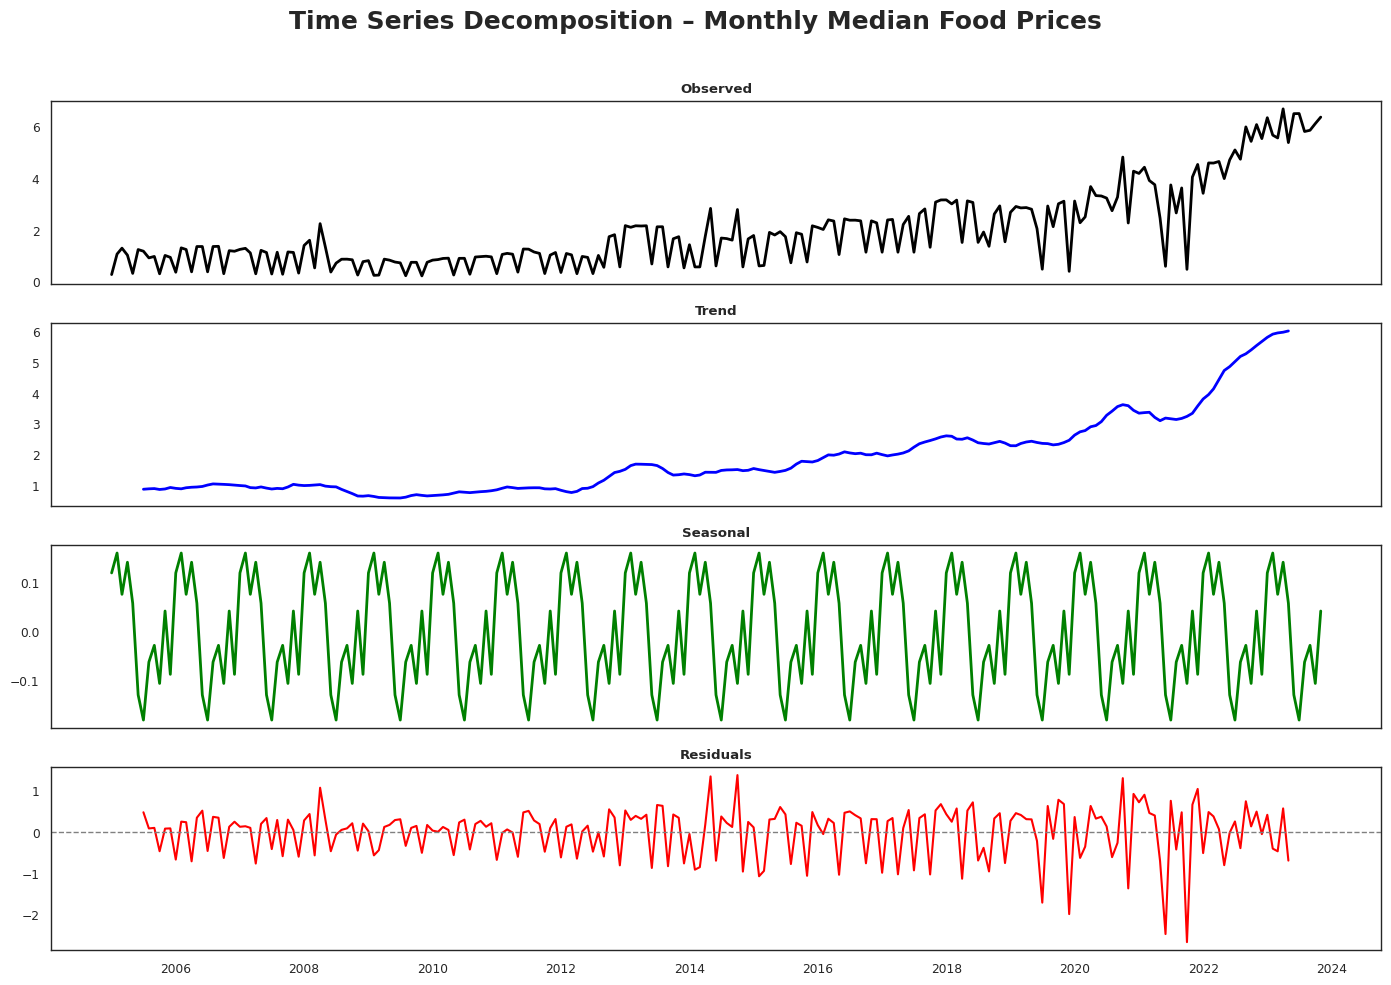

In [39]:
# Create year-month index
haiti_df['year_month'] = haiti_df['date'].dt.to_period('M')

# Monthly median prices
monthly_prices = (haiti_df.groupby('year_month')['usdprice'].median().to_timestamp())

# Decompose with monthly seasonality (period = 12)
decomp_monthly = seasonal_decompose(monthly_prices, model='additive', period=12)

# Extract each components
observed = decomp_monthly.observed
trend = decomp_monthly.trend
seasonal = decomp_monthly.seasonal
resid = decomp_monthly.resid

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
sns.set_style("white")
sns.set_context("paper")

# Observed plot
axes[0].plot(observed, color="black", linewidth=2)
axes[0].set_title("Observed", weight="bold")

# Trend plot
axes[1].plot(trend, color="blue", linewidth=2)
axes[1].set_title("Trend", weight="bold")

# Seasonal plot
axes[2].plot(seasonal, color="green", linewidth=2)
axes[2].set_title("Seasonal", weight="bold")

# Residuals plot
axes[3].plot(resid, color="red", linewidth=1.5)
axes[3].axhline(0, color="gray", linestyle="--", linewidth=1)
axes[3].set_title("Residuals", weight="bold")

fig.suptitle("Time Series Decomposition – Monthly Median Food Prices",
             fontsize=18, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### **Time Series Decomposition Summary**

- **Observed:** Shows the overall monthly price trend, with a clear post‑2019 acceleration in food costs.  
- **Trend:** Reveals a steady rise from 2005 to 2019, followed by a sharp inflation surge after 2020.
- **Seasonal:** Highlights recurring monthly patterns. Since it's about staple goods, it could be tied to harvest cycles and import schedules.
- **Residuals:** Mostly random noise, with occasional spikes signaling shocks such as insecurity or supply disruptions.


<br></br>

## **Regional Price Forecast Comparison: Artibonite, Noth-West, and West**

This section compares forecasted food price trends across three Haitian departments using ARIMA models tailored to each region's volatility and structural behavior.

**Artibonite Price Forecast**

In [7]:
# Filter Artibonite series
art_series = dept_year[dept_year['Department'] == 'Artibonite'].set_index('year')['usdprice']

# Log transform + Difference 2nde order (because variance was unstable)
art_log = np.log1p(art_series)
art_log_diff2 = art_log.diff().diff().dropna()

adf_result_log2 = adfuller(art_log_diff2)
print("ADF Statistic (log + diff2):", adf_result_log2[0])
print("p-value:", adf_result_log2[1])

# Fit ARIMA with d = 2
model_art = ARIMA(art_log, order=(1, 2, 1))
fit_art = model_art.fit()

print(fit_art.summary())

# Forecast next 5 years
forecast_art = fit_art.get_forecast(steps=5)
forecast_ci_art = forecast_art.conf_int()


ADF Statistic (log + diff2): -11.475623050686591
p-value: 5.1396652111647816e-21


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               usdprice   No. Observations:                   18
Model:                 ARIMA(1, 2, 1)   Log Likelihood                  11.670
Date:                Fri, 02 Jan 2026   AIC                            -17.340
Time:                        22:59:10   BIC                            -15.023
Sample:                             0   HQIC                           -17.222
                                 - 18                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5008      0.225     -2.223      0.026      -0.942      -0.059
ma.L1         -0.7436      0.391     -1.904      0.057      -1.509       0.022
sigma2         0.0122      0.005      2.581      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#### **Result Interpretation for Artibonite**
#### Coefficients:
* AR(1) coefficient = -0.50, p = 0.026: Strong and statistically significant autoregressive effect. Past values strongly influence current ones.

* MA(1) coefficient = −0.74, p = 0.057: Borderline significant and not as strong as the AR term. Useful to smooth irregulrities in the differenced series.

* sigma = 0.0122(p=0.010): Residual is small and statistically meaningful, thus the model captures most of the structure in the data.

#### Diagnostics:
* Ljung-Box Q (p = 0.82): Residuals show no significant autocorrelation, signaling that the model is not missing obvious patterns.

* Jarque-Bera (p = 0.84): Residuals are approximately normally distributed.

* Heteroskedasticity (p = 0.19): Residuals are stable.

* Skew = 0.35, Kurtosis = 3.19: Residuals are slighly skew to the right and close to normal distribution (ideal is skew ≈ 0, kurtosis ≈ 3).
<br></br>
### What it Means for Artibonite Forecast:
**The ARIMA(1,2,1) model is adequate: no residuals autocorrelation, AR term is strongly significant, MA term is barely significant, and diagnostics are clean (residuals are normally distributed). This suggest that sudden shocks are not the dominant forces in Artibonite region. Instead, the forecast mirrors the inflationary and import-dependent pressure that defines its natural market trend (growing inflation, currency depreciation, and dependence on imported goods).**

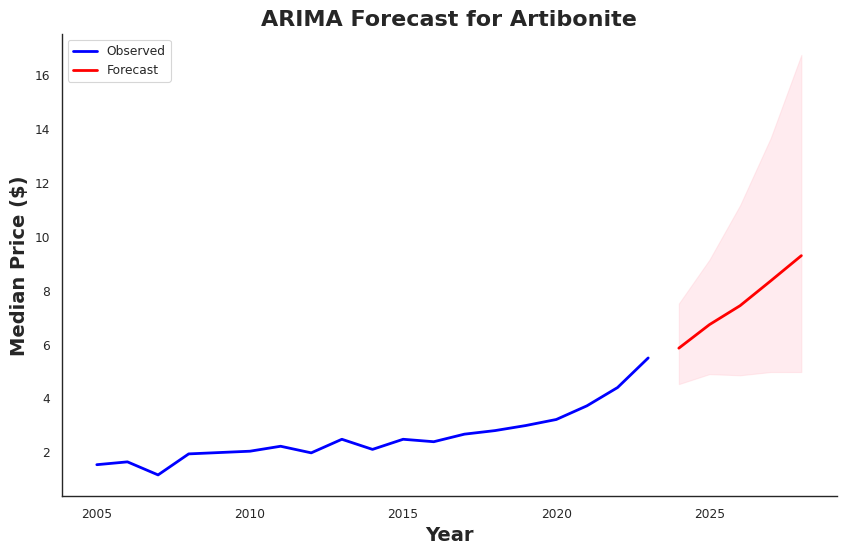

In [36]:
observed = art_series

# Back-transform forecast from log to USD
forecast_values = np.expm1(forecast_art.predicted_mean)
forecast_lower = np.expm1(forecast_ci_art.iloc[:, 0])
forecast_upper = np.expm1(forecast_ci_art.iloc[:, 1])

# Create forecast horizon years
last_year = observed.index[-1]
future_years = range(last_year + 1, last_year + 6)

# Plot
sns.set_style("white")
sns.set_context("paper")
plt.figure(figsize=(10,6))
plt.plot(observed.index, observed, label="Observed", color="blue", linewidth=2) # observed series
plt.plot(future_years, forecast_values, label="Forecast", color="red", linewidth=2) # forecast line
# Confidence interval
plt.fill_between(future_years, forecast_lower, forecast_upper,
                 color="pink", alpha=0.3)

plt.title("ARIMA Forecast for Artibonite", fontsize=16, weight='bold')
plt.xlabel("Year", fontsize=14, weight='bold')
plt.ylabel("Median Price ($)", fontsize=14, weight='bold')
plt.legend()
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()


<br></br>

**North-West Price Forecast**


In [9]:
# Filter north-west series
nw_series = dept_year[dept_year['Department'] == 'North-West'].set_index('year')['usdprice']
nw_log = np.log1p(nw_series)  # log(1+x) to avoid log(0)
nw_log_diff = nw_log.diff().diff().diff().dropna()

# Check stationarity
adf_result = adfuller(nw_log_diff)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

# Fit ARIMA
model_nw = ARIMA(nw_log, order=(1,2,1))
fit_nw = model_nw.fit()
print(fit_nw.summary())

# Forecast next 5 years
forecast_nw = fit_nw.get_forecast(steps=5)
forecast_ci_nw = forecast_nw.conf_int()

ADF Statistic: -4.5656990777986755
p-value: 0.0001493384085128746


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               usdprice   No. Observations:                   18
Model:                 ARIMA(1, 2, 1)   Log Likelihood                   6.628
Date:                Fri, 02 Jan 2026   AIC                             -7.256
Time:                        23:00:41   BIC                             -4.939
Sample:                             0   HQIC                            -7.138
                                 - 18                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1127      0.326     -0.345      0.730      -0.752       0.527
ma.L1         -0.7992      0.402     -1.990      0.047      -1.586      -0.012
sigma2         0.0237      0.012      1.928      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#### **Result Interpretation for North‑West**
#### Coefficients:
* AR(1) = -0.1127 (p = 0.730) suggest no autoregressive effect, indicating that past values of the series does not predict future values.

* MA(1) = -0.7992 (p = 0.047): Significant, thus capturing short-term shocks well.

* Sigma2 = 0.0629 (p = 0.054): Borderline significant, as the model captures most of the structure but some noise remains.

### Diagnostics:
* Ljung‑Box Q (p = 0.74): Residuals show no autocorrelation.

* Jarque‑Bera (p = 0.83):  Residuals are normally distributed.

* Heteroskedasticity (p = 0.27): Residuals are borderline stable, suggesting slight variance instability.

* Skew = −0.37, Kurtosis = 3.04: Residuals are close to normal shape.
<br></br>
### What it Means for North-West Forecast:
**The ARIMA(1,2,1) provides the best balance of statistical fit and economic interpretability for the North‑West region. The significant MA(1) term indicates that North-West is dominated by sudden shocks rather than market trend, meaning that external shocks (insecurity, road blockages, supply disruptions, and other structural constraints) create abrupt price movements that this model captures well. In other words, instead of following a smooth, predictable trajectory, North-West prices respond to short-term disruptions, reflecting the region's fragile market conditions and chronic volatility.**

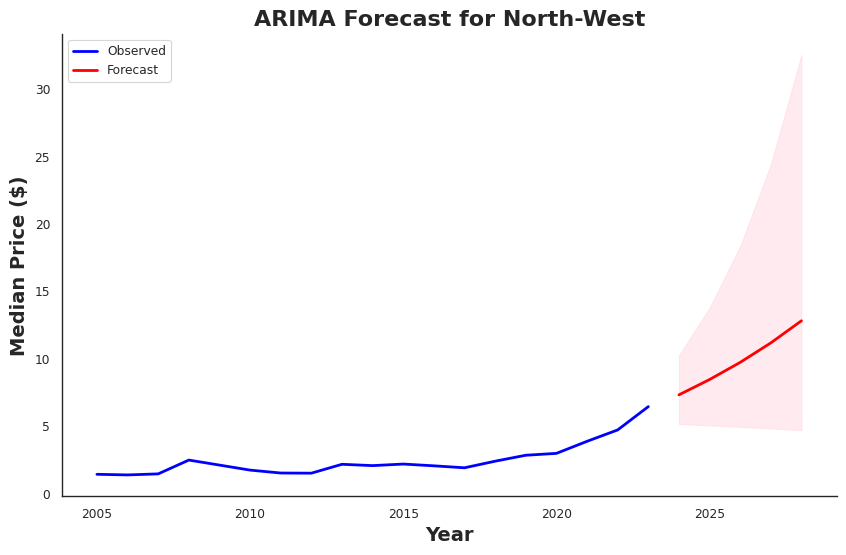

In [37]:
forecast_values_nw = np.expm1(forecast_nw.predicted_mean)
forecast_lower_nw = np.expm1(forecast_ci_nw.iloc[:, 0])
forecast_upper_nw = np.expm1(forecast_ci_nw.iloc[:, 1])

observed_nw = nw_series
last_year_nw = observed_nw.index[-1]
future_years_nw = range(last_year_nw + 1, last_year_nw + 6)

plt.figure(figsize=(10,6))
sns.set_style("white")
sns.set_context("paper")
plt.plot(observed_nw.index, observed_nw, label="Observed", color="blue",linewidth=2)
plt.plot(future_years_nw, forecast_values_nw, label="Forecast", color="red", linewidth=2)

plt.fill_between(future_years_nw, forecast_lower_nw, forecast_upper_nw,
                 color="pink", alpha=0.3)

plt.title("ARIMA Forecast for North-West", fontsize=16, weight='bold')
plt.xlabel("Year", fontsize=14, weight='bold')
plt.ylabel("Median Price ($)", fontsize=14, weight='bold')
plt.legend()
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()


<br></br>

**West Price Forecast**


Because West’s price series reflects structural stagnation rather than trend-driven inflation, ARIMA(1,1,2) provides the most stable and interpretable model, even though the ADF test does not indicate stationarity after multiple differences.

In [11]:
# Filter West series
west_series = dept_year[dept_year['Department'] == 'West'].set_index('year')['usdprice']
west_log = np.log1p(west_series)  # log(1+x) to avoid log(0
west_diff = west_log.diff().dropna()
# Check stationarity
adf_result = adfuller(west_diff)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

# Fit ARIMA (same order (1,1,1))
model_west = ARIMA(west_log, order=(1,1,2))
fit_west = model_west.fit()
print(fit_west.summary())

# Forecast next 5 years
forecast_west = fit_west.get_forecast(steps=5)
forecast_ci_west = forecast_west.conf_int()

ADF Statistic: 1.0962453533348675
p-value: 0.9951844504638755


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               usdprice   No. Observations:                   19
Model:                 ARIMA(1, 1, 2)   Log Likelihood                  11.925
Date:                Fri, 02 Jan 2026   AIC                            -15.850
Time:                        23:02:45   BIC                            -12.288
Sample:                             0   HQIC                           -15.359
                                 - 19                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9757      0.096     10.142      0.000       0.787       1.164
ma.L1         -1.7494      6.224     -0.281      0.779     -13.948      10.449
ma.L2          0.9926      7.205      0.138      0.8

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#### **Result Interpretation for West**

#### Coefficients:
* AR(1) = 0.9757 (p = 0.001) suggest a highly significant autoregressive effect. Past values strongly influence current ones.

* MA(1) and MA(2) = −0.88 (both p = >0.05): The Moving Average is not statistically significant, so it doesn't add much explanatory power.

* Sigma2 = 0.0111 (p = 0.887). The model doesn't capture volatility well.

### Diagnostics:
* Ljung‑Box Q (p = 0.87): Residuals show no strong autocorrelation, but it's close to the 0.05 threshold. The model is mostly adequate, but worth checking higher lags.

* Jarque‑Bera (p = 0.02): Residuals are not normally distributed, likely because of occasional price shocks in the West.

* Heteroskedasticity (p = 0.51): Residuals are stable.

* Skew = 1.34, Kurtosis = 4.95: Residuals are rihgt-skewed and  heavily-tailed. This indicateshigh price asymmetry, likely with the consistent insecurity crisis and supply disruptions.
<br></br>

### What it means for West Forecast:
**The ARIMA(1,1,2) model for West shows that prices barely move, reflecting a market where normal inflationary forces are overshadowed by chronic instability. Instead of following a steady upward trend, prices remain unusually flat because persistent insecurity, blocked transport routes, and repeated disruptions suppress both supply and demand. Overall, the West behaves like a paralyzed market, shaped by more instability and disruption than by predictable economic forces.**

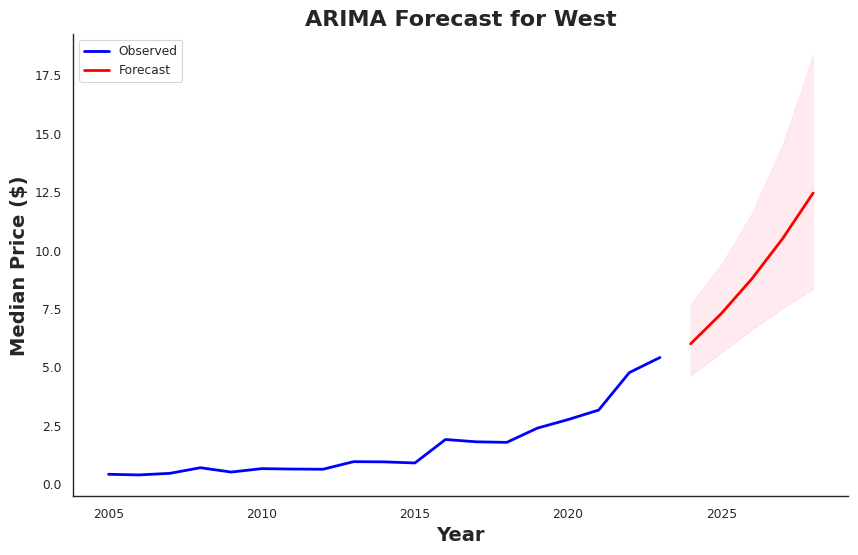

In [38]:
forecast_values_west = np.expm1(forecast_west.predicted_mean)
forecast_lower_west = np.expm1(forecast_ci_west.iloc[:, 0])
forecast_upper_west = np.expm1(forecast_ci_west.iloc[:, 1])
observed_west = west_series
last_year_west = observed_west.index[-1]
future_years_west = range(last_year_west + 1, last_year_west + 6)

# Plot West forecast
plt.figure(figsize=(10,6))
sns.set_style("white")
sns.set_context("paper")
plt.plot(observed_west.index, observed_west, label="Observed", color="blue", linewidth=2)
plt.plot(future_years_west, forecast_values_west, label="Forecast", color="red", linewidth=2)
plt.fill_between(future_years_west, forecast_lower_west, forecast_upper_west,
                 color="pink", alpha=0.3)

plt.title("ARIMA Forecast for West", fontsize=16, weight='bold')
plt.xlabel("Year", fontsize=14, weight='bold')
plt.ylabel("Median Price ($)", fontsize=14, weight='bold')
plt.legend()
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()


<br></br>
### **Directional Forecast Summary**
#### **Artibonite:**  
The forecast rises steadily, extending its long‑run trend. Prices keep climbing slowly but persistently, reflecting ongoing inflation and import dependence.

#### **North‑West:**
The forecast also moves upward but with more volatility. Wider confidence bands reflect a shock‑driven region shaped by instability and supply disruptions.

#### **West:**
The forecast stays almost flat. This stagnation signals a paralyzed market where chronic insecurity and disrupted supply chains suppress normal price movement.

## Why the West's Price Prediction Might be Worse?

Price stagnation in Haiti’s West department does not signal stability but rather severe market paralysis. In Port‑au‑Prince, armed groups disrupt transport and market access, cutting off the flow of goods and creating artificial scarcity. Combined with high national inflation and heavy reliance on imports, households face rising costs without local production to cushion the blow. At the same time, widespread displacement and acute food insecurity suppress demand, while insecurity prevents trucks from reaching markets and breaks rural‑urban supply chains. Together, these pressures explain why prices in the West appear flat, but actually is a **reflection of economic dysfunction and suppressed market activity** rather than equilibrium.

Sources:
1. [IPC Acute Food Insecurity Snapshot](https://www.ipcinfo.org/fileadmin/user_upload/ipcinfo/docs/IPC_Haiti_Acute_Food_Insecurity_Mar_Jun2025_Snapshot_English.pdf)
2. [Fews NET Food Security Outlook](https://fews.net/latin-america-and-caribbean/haiti/food-security-outlook/october-2024)
3. [FAO GIEWS Country Brief](https://www.fao.org/giews/countrybrief/country.jsp?code=HTI)
4. [UN News – Record hunger in Haiti](https://news.un.org/en/story/2025/04/1162391)

<br></br>

### **Model Visual Diagnostic**

#### For Artibonite

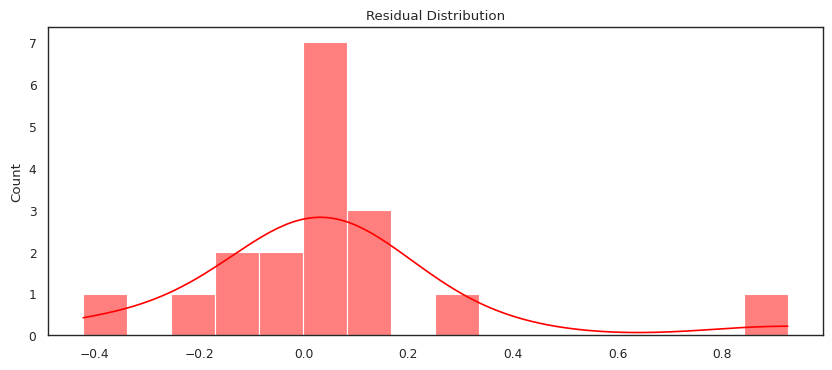

In [13]:
# Residuals from ARIMA model
residuals = fit_art.resid

#  Histogram of residuals
plt.figure(figsize=(10,4))
sns.histplot(residuals, kde=True, color="red")
plt.title("Residual Distribution")
plt.show()

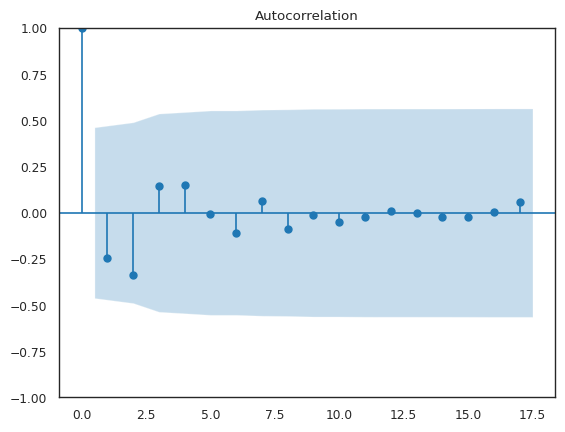

In [14]:
# Safe lag selection for ACF and PACF
max_lags_acf = min(20, len(residuals) - 1)          # ACF can go up to n-1
max_lags_pacf = min(len(residuals) // 2 - 1, 20)    # PACF must be < 50% of sample size

# Autocorrelation (ACF) plot
plot_acf(residuals, lags=max_lags_acf)
plt.show()

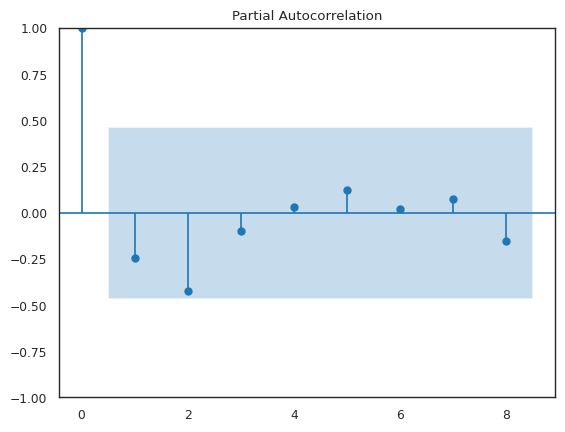


     lb_stat  lb_pvalue
10  5.781062    0.83331


In [15]:
# Partial Auto Correlation (PACF) plot
plot_pacf(residuals, lags=max_lags_pacf)
plt.show()

# Ljung-Box test for autocorrelation
ljung_box = acorr_ljungbox(residuals, lags=[min(10, len(residuals) - 1)], return_df=True)
print()
print(ljung_box)

### Interpretation:
The p-value is very high (>0.05). This  means that ARIMA residuals do not show significant autocorrelation, suggesting that the model captures the structure of the data reasonably well.

<br></br>

#### For West

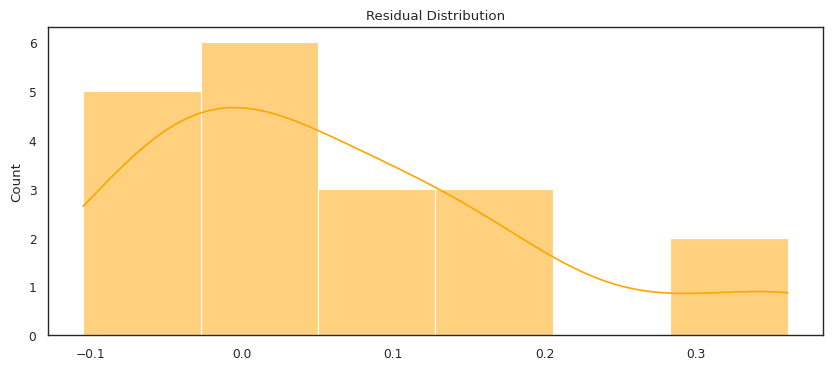

In [16]:
# Residuals from ARIMA model
residuals = fit_west.resid

#  Histogram of residuals
plt.figure(figsize=(10,4))
sns.histplot(residuals, kde=True, color="orange")
plt.title("Residual Distribution")
plt.show()

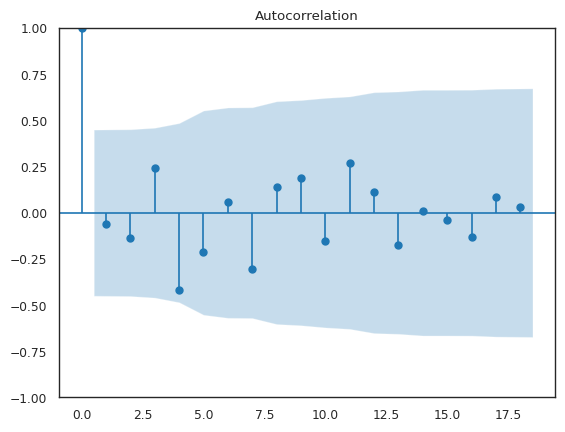

In [17]:
# Safe lag selection for ACF and PACF
max_lags_acf = min(20, len(residuals) - 1)          # ACF can go up to n-1
max_lags_pacf = min(len(residuals) // 2 - 1, 20)    # PACF must be < 50% of sample size

# Autocorrelation (ACF) plot
plot_acf(residuals, lags=max_lags_acf)
plt.show()

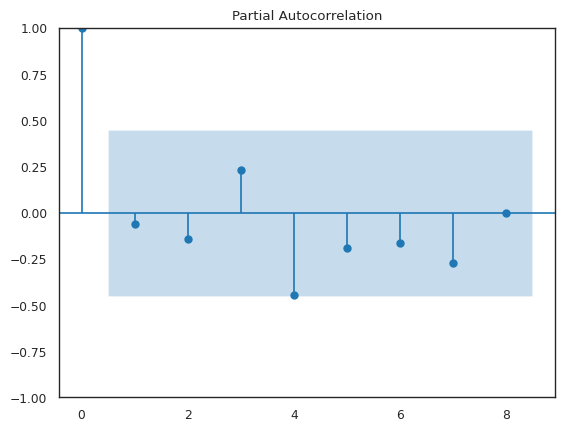


      lb_stat  lb_pvalue
10  14.375662   0.156536


In [18]:
# Partial Auto Correlation (PACF) plot
plot_pacf(residuals, lags=max_lags_pacf)
plt.show()

# Ljung-Box test for autocorrelation
ljung_box = acorr_ljungbox(residuals, lags=[min(10, len(residuals) - 1)], return_df=True)
print()
print(ljung_box)

### Interpretation:
Since p > 0.05, we fail to reject the null that residuals do not show significant autocorrelation.
This is a good sign because the ARIMA model for West is capturing the structure well, and the residuals behave like random noise.

<br></br>

#### For North-West

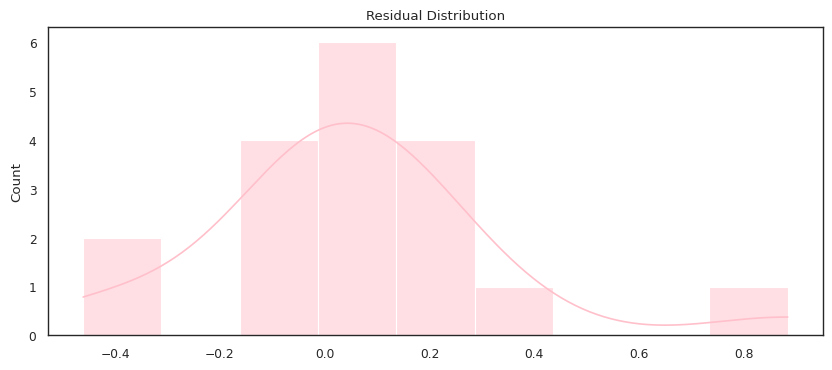

In [19]:
# Residuals from ARIMA model
residuals = fit_nw.resid

#  Histogram of residuals
plt.figure(figsize=(10,4))
sns.histplot(residuals, kde=True, color="pink")
plt.title("Residual Distribution")
plt.show()

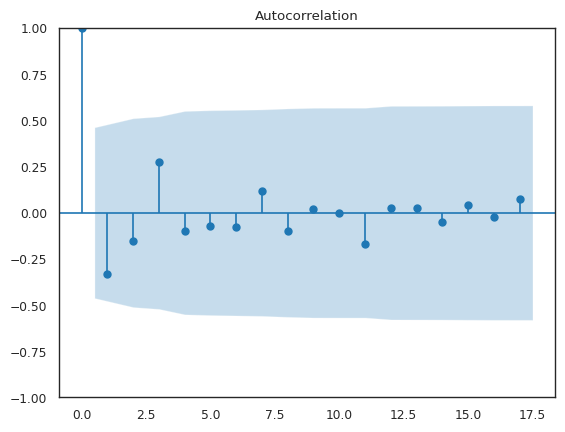

In [20]:
# Safe lag selection for ACF and PACF
max_lags_acf = min(20, len(residuals) - 1)
max_lags_pacf = min(len(residuals) // 2 - 1, 20)    # PACF must be < 50% of sample size

# Autocorrelation (ACF) plot
plot_acf(residuals, lags=max_lags_acf)
plt.show()

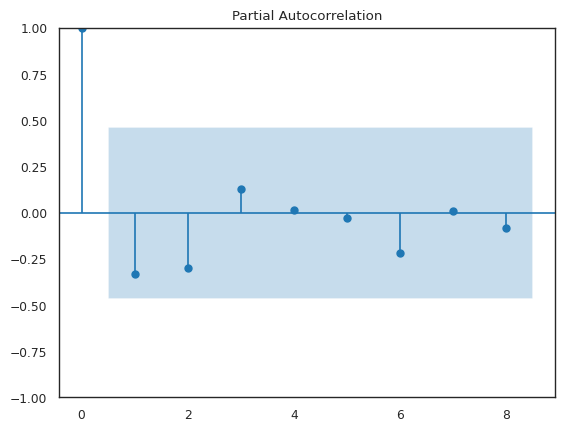


    lb_stat  lb_pvalue
10  6.07705   0.808749


In [21]:
# Partial Auto Correlation (PACF) plot
plot_pacf(residuals, lags=max_lags_pacf)
plt.show()

# Ljung-Box test for autocorrelation
ljung_box = acorr_ljungbox(residuals, lags=[min(10, len(residuals) - 1)], return_df=True)
print()
print(ljung_box)

### Interpretation

Since p > 0.05, we fail to reject the null that the residuals show no significant autocorrelation. Similar to the other department's residuals, the ARIMA model for North‑West has captured the structure well, leaving residuals that behave like random noise.



---



# **Findings**

The time‑series forecasts reveal how national pressures manifest differently across Haiti's regions. Artibonite follows a steady, predictable upward trajectory, reflecting a market driven by persistent inflation and the structural weight of import dependence. North‑West, by contrast, shows a sharper and more volatile rise: the model captures a shock‑driven environment marked by insecurity, fragile supply chains, and frequent disruptions, resulting in steeper forecasts and wider uncertainty bands.

West, where Haiti's capital is, stands apart from both. Instead of rising in line with national inflationary pressures, its forecast remains nearly flat. This stagnation does not signal stability but rather a market constrained by chronic insecurity, blocked transport routes, and disrupted economic activity; conditions that suppress normal price movement and reduce the region's responsiveness to broader trends. These regional differences are consistent with the decomposition results, which show a strong national trend alongside irregular shocks that shape each department’s price dynamics differently.